In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [2]:
import os
import sys

In [3]:
# chaging directory

In [4]:
root, *_ = !pwd

In [5]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [6]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [9]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [10]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [11]:
train_data.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
date,,,,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN


In [12]:
# train_data = train_data[train_data.index > '2021-01-01']

### season

In [13]:
from pipeline.season import *

In [14]:
### template

In [15]:
dates = train_data.reset_index()[['date']]

In [16]:
dates = date_preprocessing(dates, RAW_PATH / 'seasons.csv',
                   date_attr=['year', 'month', 'week'])

src/pipeline/season.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[attr] = getattr(df[dt_col].dt, attr)


In [17]:
dates

,date,year,month,week,inSeason,seasonPart
0,2018-01-01,2018,1,1,False,Offseason
1,2018-01-02,2018,1,1,False,Offseason
2,2018-01-03,2018,1,1,False,Offseason
3,2018-01-04,2018,1,1,False,Offseason
4,2018-01-05,2018,1,1,False,Offseason
...,...,...,...,...,...,...
1211,2021-04-26,2021,4,17,True,Reg Season 1st Half
1212,2021-04-27,2021,4,17,True,Reg Season 1st Half
1213,2021-04-28,2021,4,17,True,Reg Season 1st Half
1214,2021-04-29,2021,4,17,True,Reg Season 1st Half


### players

In [18]:
from pipeline.players import *

In [19]:
players = pd.read_csv(RAW_PATH / 'players.csv', parse_dates=['DOB', 'mlbDebutDate'])

In [20]:
pp = player_preprocessing(players)

In [21]:
pp.isna().mean()

playerId               0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
dtype: float64

### target 

In [22]:
from pipeline.target import target_preprocessing

In [23]:
unpack_target_tmf = make_unpack_tmf('nextDayPlayerEngagement')

target_pipeline = Pipeline([('unpack_target', unpack_target_tmf),
                            ('preprocessing', FunctionTransformer(target_preprocessing))])

In [24]:
%time target = target_pipeline.fit_transform(train_data)

CPU times: user 16.5 s, sys: 287 ms, total: 16.7 s
Wall time: 16.7 s


In [25]:
target.head()

,playerId,target1,target2,target3,target4,date,target_avg
0,628317,0.011167,4.474708,0.005168,5.735294,2018-01-01,2.556584
1,547989,0.042993,5.593385,0.045033,2.794118,2018-01-01,2.118882
2,519317,0.974327,56.177043,13.693746,64.166667,2018-01-01,33.752945
3,607625,0.006700,2.675097,0.005168,1.862745,2018-01-01,1.137428
4,592547,0.001117,0.632296,0.002953,0.931373,2018-01-01,0.391934


In [26]:
# target = target[target.playerId.isin(target.playerId.unique()[:2])]

In [27]:

# target.reset_index(inplace=True, drop=True)

In [28]:
target.head()

,playerId,target1,target2,target3,target4,date,target_avg
0,628317,0.011167,4.474708,0.005168,5.735294,2018-01-01,2.556584
1,547989,0.042993,5.593385,0.045033,2.794118,2018-01-01,2.118882
2,519317,0.974327,56.177043,13.693746,64.166667,2018-01-01,33.752945
3,607625,0.006700,2.675097,0.005168,1.862745,2018-01-01,1.137428
4,592547,0.001117,0.632296,0.002953,0.931373,2018-01-01,0.391934


### rosters 

In [29]:
unpack_rosters = make_unpack_tmf('rosters')

In [30]:
rosters = unpack_rosters.fit_transform(train_data)

In [31]:
rosters.head()

,playerId,gameDate,teamId,statusCode,status,date
0,400121,2018-01-01,116,A,Active,2018-01-01
1,408045,2018-01-01,142,A,Active,2018-01-01
2,425492,2018-01-01,120,A,Active,2018-01-01
3,429664,2018-01-01,136,A,Active,2018-01-01
4,431151,2018-01-01,121,A,Active,2018-01-01


In [32]:
rosters.rename(columns={'gameDate': 'rosterDate'}, inplace=True)

In [33]:
rosters = rosters[['playerId', 'date', 'status', 'teamId', 'rosterDate']]


### player twitter

In [34]:
train_data.columns

Index(['nextDayPlayerEngagement', 'games', 'rosters', 'playerBoxScores',
       'teamBoxScores', 'transactions', 'standings', 'awards', 'events',
       'playerTwitterFollowers', 'teamTwitterFollowers'],
      dtype='object')

In [35]:
unpack_tw = make_unpack_tmf('playerTwitterFollowers')

In [36]:
tw = unpack_tw.fit_transform(train_data)

In [37]:
tw.head()

,date,playerId,playerName,accountName,twitterHandle,numberOfFollowers
0,2018-01-01,545361,Mike Trout,Mike Trout,@miketrout,2452409
1,2018-01-01,506433,Yu Darvish,Yu Darvish,@faridyu,1945081
2,2018-01-01,434378,Justin Verlander,Justin Verlander,@justinverlander,1795985
3,2018-01-01,430897,Nick Swisher,Nick Swisher,@nickswisher,1711807
4,2018-01-01,120074,David Ortiz,David Ortiz,@davidortiz,1515463


In [38]:
ptw = tw[['playerId', 'date', 'numberOfFollowers']]

In [39]:
ptw.loc[:, 'accountInitDate'] = ptw.groupby('playerId')['date'].transform('min')

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### player stats 

In [40]:
unpack_pgame_stats = make_unpack_tmf('playerBoxScores')

In [43]:
pgame_stats = unpack_pgame_stats.fit_transform(train_data)

In [ ]:
pgame_stats.columns

### merge 

In [63]:
# import gc
# del train_data
# gc.collect()

In [80]:
def ffill_forward(df, features, id_feats = ['playerId'], limit: int = None):
    ff_df = df.groupby(id_feats)[features].ffill(limit=limit)
    df.update(ff_df)
    return df

In [81]:
df = target.copy()

In [82]:
df.sort_values(by=['playerId', 'date'], inplace=True)

In [83]:
df = df.merge(dates, on=['date'], how='left')

In [84]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,year,month,week,inSeason,seasonPart
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424,2018,1,1,False,Offseason
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345,2018,1,1,False,Offseason
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104,2018,1,1,False,Offseason
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896,2018,1,1,False,Offseason
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389,2018,1,1,False,Offseason


In [85]:
df.isna().mean()

playerId      0.0
target1       0.0
target2       0.0
target3       0.0
target4       0.0
date          0.0
target_avg    0.0
year          0.0
month         0.0
week          0.0
inSeason      0.0
seasonPart    0.0
dtype: float64

In [86]:
df = df.merge(pp, on=['playerId'], how='left')

In [87]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
dtype: float64

In [88]:
df.columns

Index(['playerId', 'target1', 'target2', 'target3', 'target4', 'date',
       'target_avg', 'year', 'month', 'week', 'inSeason', 'seasonPart', 'DOB',
       'mlbDebutDate', 'birthCountry', 'weight', 'primaryPositionName',
       'player_in_test', 'height', 'playerBMI'],
      dtype='object')

In [89]:
# filter only those players on the test set

In [90]:
# df = df.query('player_in_test').reset_index(drop=True)

In [91]:
# merging team names

In [92]:
df = df.merge(rosters, on=['date', 'playerId'], how='left')

In [93]:
df = ffill_forward(df, features=rosters.columns.drop('date'), limit=10)

In [94]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
status                 0.419431
teamId                 0.419431
rosterDate             0.419431
dtype: float64

In [111]:
df = df.merge(ptw, on=['date', 'playerId'], how='left')

In [112]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
status                 0.419431
teamId                 0.419431
rosterDate             0.419431
playerAge              0.000000
playerTSinceDebut      0.017467
playerDebutAge         0.017467
TimeSinceLastRoster    0.419431
numberOfFollowers      0.987638
accountInitDate        0.987638
dtype: float64

In [114]:
df = ffill_forward(df, features=ptw.columns.drop(['date', 'playerId']))

In [115]:
df.isna().mean()

playerId               0.000000
target1                0.000000
target2                0.000000
target3                0.000000
target4                0.000000
date                   0.000000
target_avg             0.000000
year                   0.000000
month                  0.000000
week                   0.000000
inSeason               0.000000
seasonPart             0.000000
DOB                    0.000000
mlbDebutDate           0.017467
birthCountry           0.000000
weight                 0.000000
primaryPositionName    0.000000
player_in_test         0.000000
height                 0.000000
playerBMI              0.000000
status                 0.419431
teamId                 0.419431
rosterDate             0.419431
playerAge              0.000000
playerTSinceDebut      0.017467
playerDebutAge         0.017467
TimeSinceLastRoster    0.419431
numberOfFollowers      0.603250
accountInitDate        0.603250
dtype: float64

In [116]:
# some feature eng for the dates
df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
df['TimeSinceLastRoster'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
df['TimeSinceLastRoster'] /= 60 * 60 * 24
# normalize
df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365

In [117]:
# import gc
# del train_data, agg_df, pgame_stats, target, dates, pp, players
# gc.collect()

In [118]:
# seasonal transformer

In [119]:
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)


def compute_fourier_calendar(dates: pd.Series,
                             freq: str = 'A',
                             order: int = 8):
    fourier = CalendarFourier(freq=freq, order=order)
    deterministic = DeterministicProcess(
                index=dates,
                order=0,
                seasonal=False,  # set to True to create indicators for days of the week (weekly seasonality)
                additional_terms=[fourier],
            )
    return deterministic.in_sample().reset_index(drop=True)

In [120]:
# _fourier_calendar_tmf = FunctionTransformer(compute_fourier_calendar, kw_args={'freq': 'A', 'order': 8})
# fourier_calendar_tmf = PdColumnTransformer([('fourier_calendar', _fourier_calendar_tmf, 'date')])

In [121]:
# categorify

In [122]:
from pandas.api.types import is_categorical_dtype
import pandas as pd
from collections import Counter

class Categorify(BaseEstimator, TransformerMixin):
    def __init__(self, top_n: int = None,
                 add_nan: bool = False,
                 dtype=np.int64):
        self.top_n = top_n
        self.add_nan = add_nan
        self.dtype = dtype

    def fit(self, X: pd.Series):
        if not isinstance(X, pd.Series):
            X = pd.Series(X)
        categories = (list(X.categories)
                      if is_categorical_dtype(X)
                      else sorted(list(f for f in X.drop_duplicates()
                                       if not pd.isna(f))))
        if self.top_n is not None:
            counter = Counter(X)
            top_categories = [cat for cat, _ in
                              counter.most_common(self.top_n)]
            categories = [cat for cat in categories
                          if cat in top_categories]
        self.categories = categories
        return self

    def transform(self, X: pd.Series) -> pd.DataFrame:
        Xcat = pd.Categorical(X, categories=self.categories, ordered=True)
        Xcodes = Xcat.codes.astype(self.dtype)
        if self.add_nan:
            Xcodes += 1
        return pd.DataFrame({X.name: Xcodes})

In [123]:
categories = ['playerId', 'seasonPart', 'birthCountry', 'teamId', 'primaryPositionName', 'status']

In [124]:
categories_pipeline = PdColumnTransformer([(name, Categorify(add_nan=True), name)
                                            for name in categories])

In [125]:
### fill nan

In [126]:
continuous_features = [name for name, values in df.items()
  if (values.dtype == np.float64) and not name.startswith('target') and not name.endswith('Id')]


In [127]:
continuous_features

['weight',
 'height',
 'playerBMI',
 'playerAge',
 'playerTSinceDebut',
 'playerDebutAge',
 'TimeSinceLastRoster',
 'numberOfFollowers']

In [128]:
def to_float32(df: pd.DataFrame, fill_value: int = -1) -> pd.DataFrame:
    for name, value in df.items():
        df[name] = value.astype(np.float32)
    return df

In [129]:
continuous_pipeline = PdColumnTransformer([('continuous_features', FunctionTransformer(to_float32),
                                            continuous_features )])

In [130]:
### putting pipeline together

In [131]:
pipeline = PdFeatureUnion([#('fourier_calendar', fourier_calendar_tmf),
                           ('categories', categories_pipeline),
                           ('continuous', continuous_pipeline)])

In [132]:
pipeline

PdFeatureUnion(transformer_list=[('categories',
                                  PdColumnTransformer(transformers=[('playerId',
                                                                     Categorify(add_nan=True),
                                                                     'playerId'),
                                                                    ('seasonPart',
                                                                     Categorify(add_nan=True),
                                                                     'seasonPart'),
                                                                    ('birthCountry',
                                                                     Categorify(add_nan=True),
                                                                     'birthCountry'),
                                                                    ('teamId',
                                                                     Categorify(add_nan

In [133]:
from datetime import datetime
from typing import Union


class SplitData:
    """Helper class to split the data for time series"""
    def __init__(self, date: Union[datetime, str],
                 train_days: int = None,
                 test_days: int = 31,
                 gap: int = 0,
                 dt_col: str = 'date'):
        if isinstance(date, str):
            date = pd.to_datetime(date)
        # test range
        self.start_test_dt = date
        self.end_test_dt =  date + pd.to_timedelta(test_days, unit='d')
        # train range
        self.end_train_dt = date - pd.to_timedelta(gap, unit='d')
        self.start_train_dt = (self.end_train_dt - pd.to_timedelta(train_days, unit='d')
                               if train_days is not None else
                               None)
        self.dt_col = dt_col
    
    @staticmethod
    def _get_index(dates: pd.Series,
                start: datetime,
                end: datetime):
        index = (dates >= start) & (dates < end)
        return index
    
    def train(self, df: pd.DataFrame) -> pd.DataFrame:
        start_train_dt = (df[self.dt_col].min()
                          if self.start_train_dt is None
                          else self.start_train_dt)
        index = self._get_index(df[self.dt_col], start_train_dt,
                                self.end_train_dt)
        return df.loc[index, :].reset_index(drop=True)

    def valid(self, df: pd.DataFrame) -> pd.DataFrame:
        index = self._get_index(df[self.dt_col], self.start_test_dt,
                                self.end_test_dt)
        return df.loc[index, :].reset_index(drop=True)
    
    def __repr__(self):
        return (f'test_range=({self.start_test_dt}, {self.end_test_dt}), '
                f'train_range=({self.start_train_dt}, {self.end_train_dt})')

In [134]:
sp = SplitData("2021-04-01")

In [135]:
train_df = sp.train(df)
valid_df = sp.valid(df)

In [136]:
train_df.date.agg(('min', 'max'))

min   2018-01-01
max   2021-03-31
Name: date, dtype: datetime64[ns]

In [137]:
valid_df.date.agg(('min', 'max'))

min   2021-04-01
max   2021-04-30
Name: date, dtype: datetime64[ns]

In [138]:
target_cols = [f'target{i}' for i in range(1, 5)];
index_cols = ['date', 'playerId'] 
target_cols, index_cols

(['target1', 'target2', 'target3', 'target4'], ['date', 'playerId'])

In [139]:
train_target = train_df.loc[:, target_cols]
valid_target = valid_df.loc[:, target_cols]

In [140]:
%%time
train_features = pipeline.fit_transform(train_df)

CPU times: user 1.69 s, sys: 210 ms, total: 1.9 s
Wall time: 1.92 s


In [141]:
%%time
valid_features = pipeline.transform(valid_df)

CPU times: user 54.6 ms, sys: 283 µs, total: 54.8 ms
Wall time: 51.3 ms


In [142]:
train_features

,playerId,seasonPart,birthCountry,teamId,primaryPositionName,status,weight,height,playerBMI,playerAge,playerTSinceDebut,playerDebutAge,TimeSinceLastRoster,numberOfFollowers
0,1,3,10,0,7,0,129.273727,1.8034,39.748993,44.638355,20.758904,23.879452,NaN,NaN
1,1,3,10,0,7,0,129.273727,1.8034,39.748993,44.641094,20.761644,23.879452,NaN,NaN
2,1,3,10,0,7,0,129.273727,1.8034,39.748993,44.643837,20.764383,23.879452,NaN,NaN
3,1,3,10,0,7,0,129.273727,1.8034,39.748993,44.646576,20.767124,23.879452,NaN,NaN
4,1,3,10,0,7,0,129.273727,1.8034,39.748993,44.649315,20.769863,23.879452,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444341,2061,5,13,22,7,3,95.254318,1.8796,26.962107,28.643835,-0.019178,28.663013,0.0,NaN
2444342,2061,5,13,22,7,3,95.254318,1.8796,26.962107,28.646576,-0.016438,28.663013,0.0,NaN
2444343,2061,5,13,22,7,3,95.254318,1.8796,26.962107,28.649315,-0.013699,28.663013,0.0,NaN
2444344,2061,5,13,22,7,3,95.254318,1.8796,26.962107,28.652056,-0.010959,28.663013,0.0,NaN


In [143]:
valid_features.head()

,playerId,seasonPart,birthCountry,teamId,primaryPositionName,status,weight,height,playerBMI,playerAge,playerTSinceDebut,playerDebutAge,TimeSinceLastRoster,numberOfFollowers
0,1,6,10,0,7,0,129.273727,1.8034,39.748993,47.887672,24.008219,23.879452,NaN,NaN
1,1,6,10,0,7,0,129.273727,1.8034,39.748993,47.890411,24.010960,23.879452,NaN,NaN
2,1,6,10,0,7,0,129.273727,1.8034,39.748993,47.893150,24.013699,23.879452,NaN,NaN
3,1,6,10,0,7,0,129.273727,1.8034,39.748993,47.895889,24.016438,23.879452,NaN,NaN
4,1,6,10,0,7,0,129.273727,1.8034,39.748993,47.898628,24.019178,23.879452,NaN,NaN


In [144]:
from dataclasses import dataclass

@dataclass
class MLBDataset:
    features: pd.DataFrame
    target: pd.DataFrame
    prediction: np.ndarray = None
    
    def get_target(self, index: int):
        return self.target.values[:, index]
    
    def set_prediction(self, pred: np.ndarray):
        self.prediction = prediction
#     @classmethod
#     def from_df(self, features: pd.DataFrame, target: pd.DataFrame)

In [145]:
train_data = MLBDataset(train_features, train_target)
valid_data = MLBDataset(valid_features, valid_target)

In [146]:
train_data

MLBDataset(features=         playerId  seasonPart  birthCountry  teamId  primaryPositionName  \
0               1           3            10       0                    7   
1               1           3            10       0                    7   
2               1           3            10       0                    7   
3               1           3            10       0                    7   
4               1           3            10       0                    7   
...           ...         ...           ...     ...                  ...   
2444341      2061           5            13      22                    7   
2444342      2061           5            13      22                    7   
2444343      2061           5            13      22                    7   
2444344      2061           5            13      22                    7   
2444345      2061           5            13      22                    7   

         status      weight  height  playerBMI  playerAge  playerTS

In [147]:
valid_data

MLBDataset(features=       playerId  seasonPart  birthCountry  teamId  primaryPositionName  \
0             1           6            10       0                    7   
1             1           6            10       0                    7   
2             1           6            10       0                    7   
3             1           6            10       0                    7   
4             1           6            10       0                    7   
...         ...         ...           ...     ...                  ...   
61825      2061           6            13      22                    7   
61826      2061           6            13      22                    7   
61827      2061           6            13      22                    7   
61828      2061           6            13      22                    7   
61829      2061           6            13      22                    7   

       status      weight  height  playerBMI  playerAge  playerTSinceDebut  \
0           0

In [148]:
# modeling

In [149]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [150]:
def fit_model(model,
              train_data,
              valid_data,
              parameters={},
              verbose=100):
    models = {}
    valid_features = valid_data.features.values
    
    for name, target in train_data.target.items():
        _model = model(**parameters)
        _model.fit(train_data.features.values, target,
                   eval_set=[(valid_features, valid_data.target[name])],  
                    early_stopping_rounds=verbose, 
                    verbose=verbose)
        models[name] = _model
    return models

def predict(models, data):
    prediction = {name.replace('target', 'yhat'): _model.predict(data.features.values)
                  for name, _model in models.items()}
    return pd.DataFrame(prediction)

In [151]:
model = LGBMRegressor

In [152]:
parameters = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}

In [153]:
models = fit_model(model, train_data,
                   valid_data,
                   parameters=parameters)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.800002
Early stopping, best iteration is:
[75]	valid_0's l1: 0.800001
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.53397
[200]	valid_0's l1: 1.51636
[300]	valid_0's l1: 1.50585
Early stopping, best iteration is:
[290]	valid_0's l1: 1.50462
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.563805
[200]	valid_0's l1: 0.563795
[300]	valid_0's l1: 0.563795
[400]	valid_0's l1: 0.563795
Early stopping, best iteration is:
[371]	valid_0's l1: 0.563795
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.25274
[200]	valid_0's l1: 1.24116
[300]	valid_0's l1: 1.21605
[400]	valid_0's l1: 1.19594
[500]	valid_0's l1: 1.18172
[600]	valid_0's l1: 1.17634
[700]	valid_0's l1: 1.17218
[800]	valid_0's l1: 1.16945
[900]	valid_0's l1: 1.1666
[1000]	valid_0's l1: 1.16254
[1100]	valid_0's l1: 1.15985
[1200]	valid_0's l1: 1.1

In [154]:
models

{'target1': LGBMRegressor(n_estimators=100000, objective='mae', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1),
 'target2': LGBMRegressor(n_estimators=100000, objective='mae', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1),
 'target3': LGBMRegressor(n_estimators=100000, objective='mae', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1),
 'target4': LGBMRegressor(n_estimators=100000, objective='mae', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1)}

In [155]:
train_predicition = predict(models, train_data)

In [156]:
valid_predicition = predict(models, valid_data)

In [157]:
for name, value in train_predicition.items():
    train_df[name] = value

In [158]:
for name, value in valid_predicition.items():
    valid_df[name] = value

In [159]:
from evaluate.metrics import *

In [160]:
def feature_importance(features, model):
    fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    fi.sort_values(by='importance', ascending=False, inplace=True)
    return fi

In [161]:
compute_metrics(train_df)

{'mae_mean': 0.9202258825086203,
 'mae_1': 0.5524807266346736,
 'mae_2': 1.6491507114958812,
 'mae_3': 0.6841304679022371,
 'mae_4': 0.7951416240016892}

In [162]:
# compute_metrics(train_predicition.values, train_data.target.values)

In [172]:
test_df = valid_df.query('player_in_test')

In [165]:
compute_metrics(valid_df)

{'mae_mean': 1.0067657468134854,
 'mae_1': 0.8000014817881353,
 'mae_2': 1.5046192357535177,
 'mae_3': 0.5637950977305018,
 'mae_4': 1.1586471719817866}

In [173]:
compute_metrics(test_df)

{'mae_mean': 1.6355978637428288,
 'mae_1': 1.3855251205395642,
 'mae_2': 2.5197092539069073,
 'mae_3': 0.9666930404557607,
 'mae_4': 1.6704640400690831}

propagating into future
{'mae_mean': 1.6467313247853896,
 'mae_1': 1.3889683816462335,
 'mae_2': 2.5448109017957328,
 'mae_3': 0.9688891498581844,
 'mae_4': 1.6842568658414077}

no propagating into future
{'mae_mean': 1.6388842818762241,
 'mae_1': 1.3858185915774184,
 'mae_2': 2.5107284715785054,
 'mae_3': 0.9686408407171874,
 'mae_4': 1.6903492236317854}

<!-- {'mae_mean': 1.0414010883800022,
 'mae_1': 0.8002031829996328,
 'mae_2': 1.6163019456575234,
 'mae_3': 0.5693593076720336,
 'mae_4': 1.1797399171908194}
 -->

{'mae_mean': 1.70179431765903,
 'mae_1': 1.3970160617017393,
 'mae_2': 2.7710200305804054,
 'mae_3': 0.9663210481188041,
 'mae_4': 1.6728201302351717}

In [167]:
fi = [feature_importance(valid_data.features.columns, _model).assign(target=name)
      for name, _model in models.items()]
fi = pd.concat(fi)
fi = fi.pivot('feature', 'target', 'importance')

In [168]:
fi = fi * 100 / fi.sum()

In [169]:
fi['mean'] = fi.mean(axis=1)
fi.sort_values(by='mean', ascending=False, inplace=True)

In [170]:
fi.head(50)

target,target1,target2,target3,target4,mean
feature,,,,,
playerTSinceDebut,15.244444,13.402299,15.615454,14.396528,14.664681
playerDebutAge,14.666667,10.643678,15.148248,11.950095,13.102172
numberOfFollowers,12.800000,8.758621,19.775382,5.587198,11.730300
playerId,2.311111,9.804598,15.247080,13.135340,10.124532
primaryPositionName,21.600000,7.390805,6.352201,4.670464,10.003367
playerAge,3.866667,8.114943,6.190476,13.588283,7.940092
seasonPart,6.977778,10.770115,0.521114,6.403580,6.168147
playerBMI,3.822222,7.068966,4.438455,9.292107,6.155437
weight,6.444444,6.436782,3.459119,7.914293,6.063660


In [200]:
scores_pp = test_df.groupby('playerId').apply(lambda x: pd.Series(compute_metrics(x)))

In [203]:
scores_pp = scores_pp.sort_values(by='mae_mean', ascending=False).reset_index()

In [224]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    sns.lineplot(x='date', y=tname, data=pdf, ax=ax, label=tname)
    sns.lineplot(x='date', y=yhat_name, data=pdf, ax=ax, label=yhat_name)
    
    ax.legend()
    

In [225]:
scores_pp.head()

,playerId,mae_mean,mae_1,mae_2,mae_3,mae_4
0,660271,34.763741,25.469788,43.852516,33.224451,36.508210
1,665487,23.450263,24.076648,13.396451,24.674266,31.653685
2,594798,21.319882,13.779135,34.385407,12.050137,25.064851
3,660670,21.028008,29.182822,20.840512,21.490734,12.597964
4,606213,19.611009,9.616790,38.976482,16.217177,13.633585


In [227]:
scores_pp.tail()

,playerId,mae_mean,mae_1,mae_2,mae_3,mae_4
1182,641561,0.004791,2.487866e-05,0.012665,1.762949e-20,0.006474
1183,608422,0.004169,4.228609e-05,0.012111,8.731858e-05,0.004435
1184,621248,0.003848,3.978499e-07,0.015316,1.762949e-20,0.000076
1185,547001,0.003417,3.978499e-07,0.007535,1.762949e-20,0.006132
1186,667297,0.003010,3.978499e-07,0.009347,1.762949e-20,0.002691


In [235]:
test_df.groupby('playerId')[['yhat1', 'yhat2', 'yhat3', 'yhat4']].std()

,yhat1,yhat2,yhat3,yhat4
playerId,,,,
405395,0.000000,0.000000,0.000000,0.000000
408234,0.092807,3.102377,0.000000,0.272711
424144,0.002743,0.306147,0.000000,0.069031
425772,0.000000,0.000000,0.000000,0.000000
425784,0.000000,0.131797,0.000000,0.006026
...,...,...,...,...
680963,0.047638,1.303313,0.005665,0.249873
681911,0.000806,0.365509,0.001584,0.055839
683232,0.000000,0.000000,0.000000,0.061743


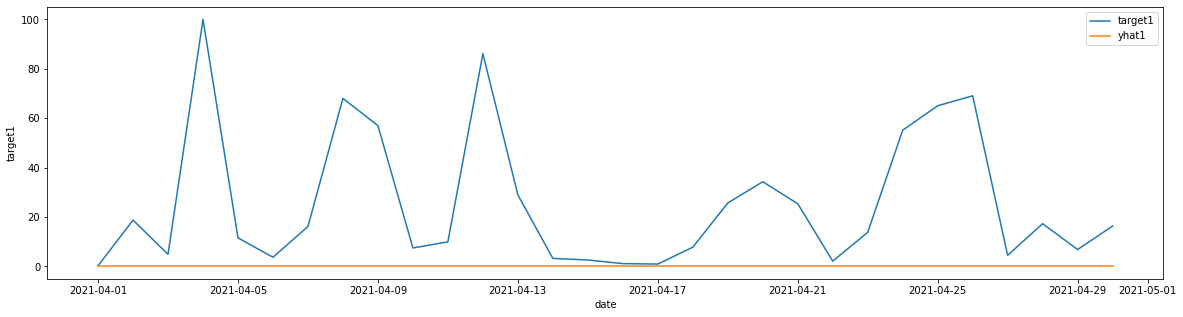

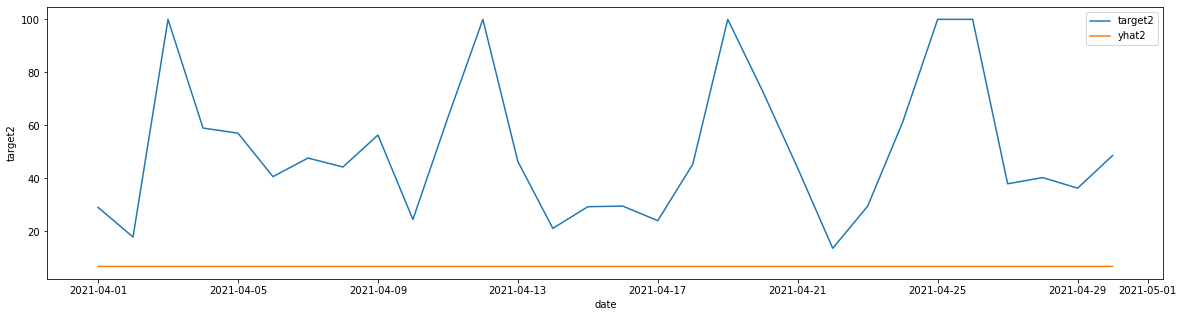

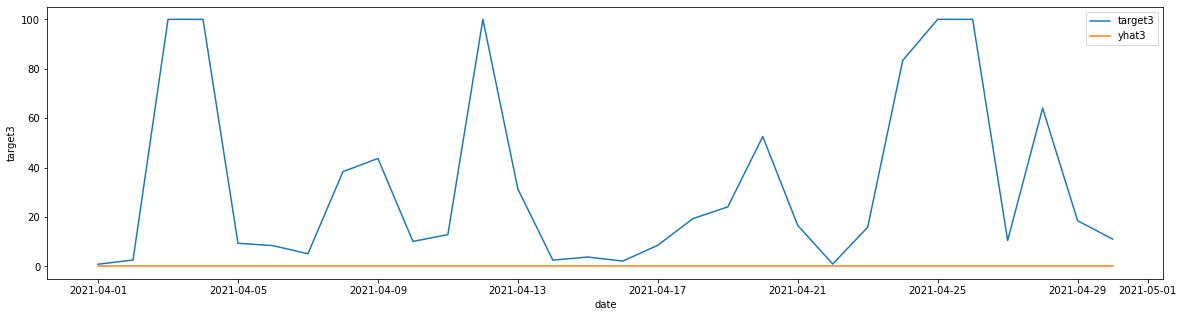

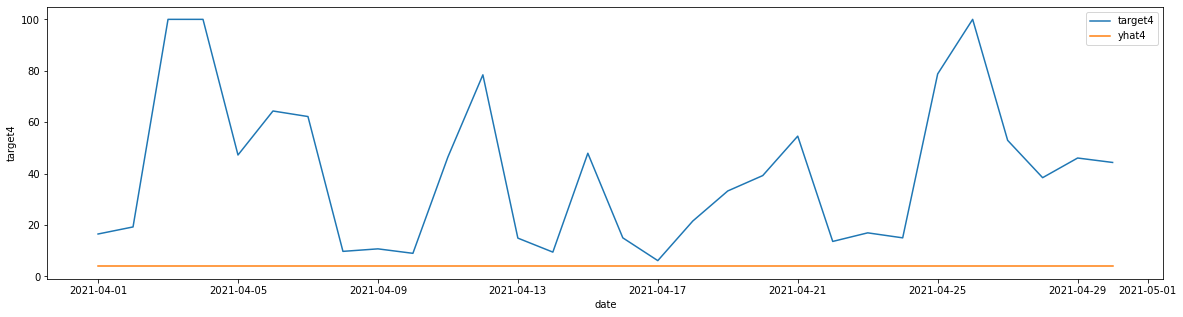

In [238]:
for index in range(1, 5):
    plot_pred(test_df, playerId=660271, index=index)